In [1]:
# YOLO kütüphanesini kur
!pip install ultralytics

import zipfile
import os

if os.path.exists("dataset.zip"):
    try:
        with zipfile.ZipFile("dataset.zip", 'r') as zip_ref:
            zip_ref.extractall("dataset") # dataset klasörüne çıkar
        print("✅ Dosyalar açıldı!")
    except zipfile.BadZipFile:
        print("❌ HATA: 'dataset.zip' dosyası geçerli bir zip dosyası değil veya bozuk! Lütfen doğru zip dosyasını yüklediğinden emin ol.")
    except Exception as e:
        print(f"❌ Zip dosyasını açarken beklenmeyen bir hata oluştu: {e}")
else:
    print("❌ Lütfen dataset.zip dosyasını sol menüye sürükleyip yükle!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 32.3 MB/s eta 0:00:00
✅ Dosyalar açıldı!


In [2]:
import shutil
import random
import os
import glob


if os.path.exists("final_dataset"):
    shutil.rmtree("final_dataset")
    print("Temiz başlangıç için 'final_dataset' klasörü temizlendi.")

base_dir = "final_dataset"
os.makedirs(f"{base_dir}/train/images", exist_ok=True)
os.makedirs(f"{base_dir}/train/labels", exist_ok=True)
os.makedirs(f"{base_dir}/val/images", exist_ok=True)
os.makedirs(f"{base_dir}/val/labels", exist_ok=True)

#
all_images_full_paths = glob.glob("dataset/**/*.jpg", recursive=True) # dataset klasörünün altındaki tüm .jpg'leri arar

if len(all_images_full_paths) == 0:
    print("❌ HATA: 'dataset' klasörünün içinde hiç .jpg resim bulunamadı! Zip dosyanı kontrol et veya doğru klasöre çıkardığından emin ol.")
    # Eğer hiç resim bulunamazsa daha fazla işlem yapmanın anlamı yok.
    # Bu noktada kodun durması veya kullanıcıya bilgi vermesi gerekir.
    # print("Lütfen zip dosyasının doğru içeriğe sahip olduğundan ve 'dataset' klasörüne doğru şekilde çıkarıldığından emin olun.")
else:
    print(f"✅ Toplam {len(all_images_full_paths)} adet resim bulundu!")
    random.shuffle(all_images_full_paths) # Karıştır

    # %80'ini eğitime ayır
    split_idx = int(len(all_images_full_paths) * 0.8)
    train_img_paths = all_images_full_paths[:split_idx]
    val_img_paths = all_images_full_paths[split_idx:]

    # Dosyaları Taşıma Fonksiyonu
    def move_files(file_paths_list, target_folder_name):
        moved_count = 0
        for img_full_path in file_paths_list:
            img_name = os.path.basename(img_full_path)


            label_full_path = img_full_path.replace("images", "labels").replace(".jpg", ".txt")

            if os.path.exists(label_full_path):
                shutil.copy(img_full_path, f"{base_dir}/{target_folder_name}/images/{img_name}")
                shutil.copy(label_full_path, f"{base_dir}/{target_folder_name}/labels/{img_name.replace('.jpg','.txt')}")
                moved_count += 1
            else:
                print(f"⚠️ UYARI: {img_name} için etiket dosyası bulunamadı ({label_full_path} bekleniyor), atlanıyor.")
        return moved_count

    n_train = move_files(train_img_paths, "train")
    n_val = move_files(val_img_paths, "val")

    print(f"✅ Veri seti ayrıldı! Eğitim: {n_train} resim, Test: {n_val} resim.")


✅ Toplam 50 adet resim bulundu!
✅ Veri seti ayrıldı! Eğitim: 40 resim, Test: 10 resim.


In [3]:
import os
import shutil
import random
from ultralytics import YOLO
import glob


print("📦 Hazırlıklar başlıyor...")
if not os.path.exists("dataset.zip"):
    print("❌ HATA: 'dataset.zip' bulunamadı! Lütfen sol menüye yüklediğinden emin ol.")
else:
    # Eski kalıntıları temizle
    !rm -rf dataset_fix final_dataset runs

    print("✅ Zip dosyası sistem komutuyla açılıyor...")
    # Python zipfile yerine doğrudan Linux komutunu kullanıyoruz (BadZipFile hatasını önler)
    !unzip -o -q dataset.zip -d dataset_fix

    # Eğer unzip başarılı olduysa klasör oluşmuş olmalı
    if os.path.exists("dataset_fix"):
        print("✅ Dosyalar başarıyla ayıklandı!")
    else:
        print("❌ HATA: Dosyalar açılamadı. Lütfen zip dosyasını silip tekrar yükle.")

# --- 2. RESİMLERİ OTOMATİK BULMA ---
all_jpgs = glob.glob("dataset_fix/**/*.jpg", recursive=True)

if len(all_jpgs) == 0:
    print("❌ HATA: Hiç .jpg bulunamadı! Zip dosyasının tam yüklendiğinden emin ol.")
else:
    print(f"✅ Toplam {len(all_jpgs)} adet resim bulundu!")

    # --- 3. KLASÖRLEME VE TAŞIMA ---
    base_dir = "final_dataset"
    os.makedirs(f"{base_dir}/train/images", exist_ok=True)
    os.makedirs(f"{base_dir}/train/labels", exist_ok=True)
    os.makedirs(f"{base_dir}/val/images", exist_ok=True)
    os.makedirs(f"{base_dir}/val/labels", exist_ok=True)

    random.shuffle(all_jpgs)
    split_idx = int(len(all_jpgs) * 0.8)
    train_imgs = all_jpgs[:split_idx]
    val_imgs = all_jpgs[split_idx:]

    def tasi_ve_duzenle(image_paths, tur):
        tasinan_sayisi = 0
        for img_path in image_paths:
            filename = os.path.basename(img_path)
            # Etiket yolunu resim yolundan türet
            label_path = img_path.replace("images", "labels").replace(".jpg", ".txt")

            if os.path.exists(label_path):
                shutil.copy(img_path, f"{base_dir}/{tur}/images/{filename}")
                shutil.copy(label_path, f"{base_dir}/{tur}/labels/{filename.replace('.jpg','.txt')}")
                tasinan_sayisi += 1
        return tasinan_sayisi

    n_train = tasi_ve_duzenle(train_imgs, "train")
    n_val = tasi_ve_duzenle(val_imgs, "val")
    print(f"✅ Hazırlık Tamam! Eğitim: {n_train}, Test: {n_val} resim.")

    # --- 4. YAPILANDIRMA ---
    yaml_content = f"path: /content/final_dataset\ntrain: train/images\nval: val/images\nnc: 1\nnames: ['Ucak']"
    with open("data.yaml", "w") as f:
        f.write(yaml_content)

    # --- 5. EĞİTİM ---
    print("🚀 EĞİTİM BAŞLIYOR!")
    model = YOLO("yolov8n.pt")
    model.train(data="data.yaml", epochs=100, imgsz=640)
    print("🎉 EĞİTİM BİTTİ!")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
📦 Hazırlıklar başlıyor...
✅ Zip dosyası sistem komutuyla açılıyor...
✅ Dosyalar başarıyla ayıklandı!
✅ Toplam 50 adet resim bulundu!
✅ Hazırlık Tamam! Eğitim: 40, Test: 10 resim.
🚀 EĞİTİM BAŞLIYOR!
Ultralytics 8.4.12 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=


image 1/1 /content/final_dataset/val/images/sentetik_26.jpg: 448x640 1 Ucak, 6.6ms
Speed: 2.3ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


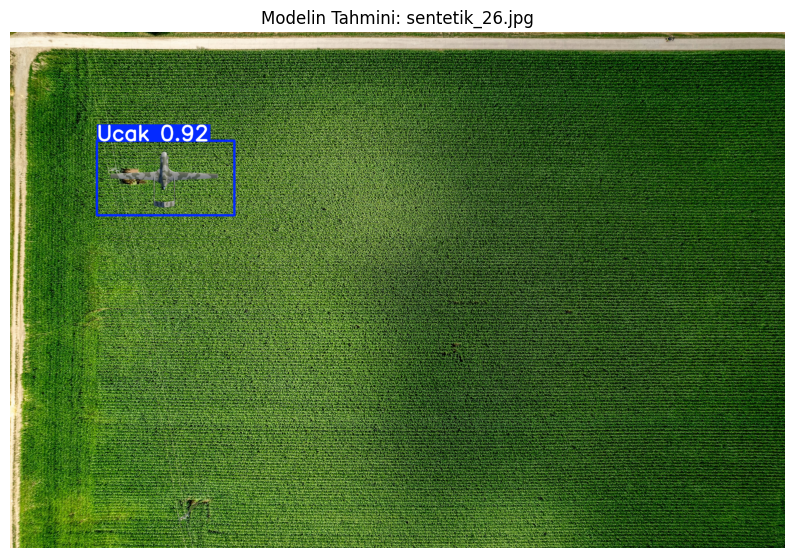

In [10]:
import matplotlib.pyplot as plt
import cv2
import os
import random

# 1. En iyi eğitilmiş modeli yüklüyoruz
# Eğitim bitince model 'runs/detect/train/weights/best.pt' adresine kaydedildi.
model = YOLO('runs/detect/train/weights/best.pt')

# 2. Test için rastgele bir resim seçelim
# Validation (Test) klasöründen bir resim alıyoruz
test_images_dir = "final_dataset/val/images"
test_files = os.listdir(test_images_dir)
random_file = random.choice(test_files)
img_path = os.path.join(test_images_dir, random_file)

# 3. TAHMİN ET! (Prediction)
# conf=0.5 : "Sadece %50'den fazla eminsen göster" demek
results = model.predict(source=img_path, conf=0.5, save=False)

# 4. Sonucu Göster
# YOLO sonucu çizilmiş halini (plot) verir, biz de ekrana basarız.
res_plot = results[0].plot()

plt.figure(figsize=(10, 10))
# Renkleri düzelt (BGR -> RGB)
plt.imshow(cv2.cvtColor(res_plot, cv2.COLOR_BGR2RGB))
plt.title(f"Modelin Tahmini: {random_file}")
plt.axis('off')
plt.show()

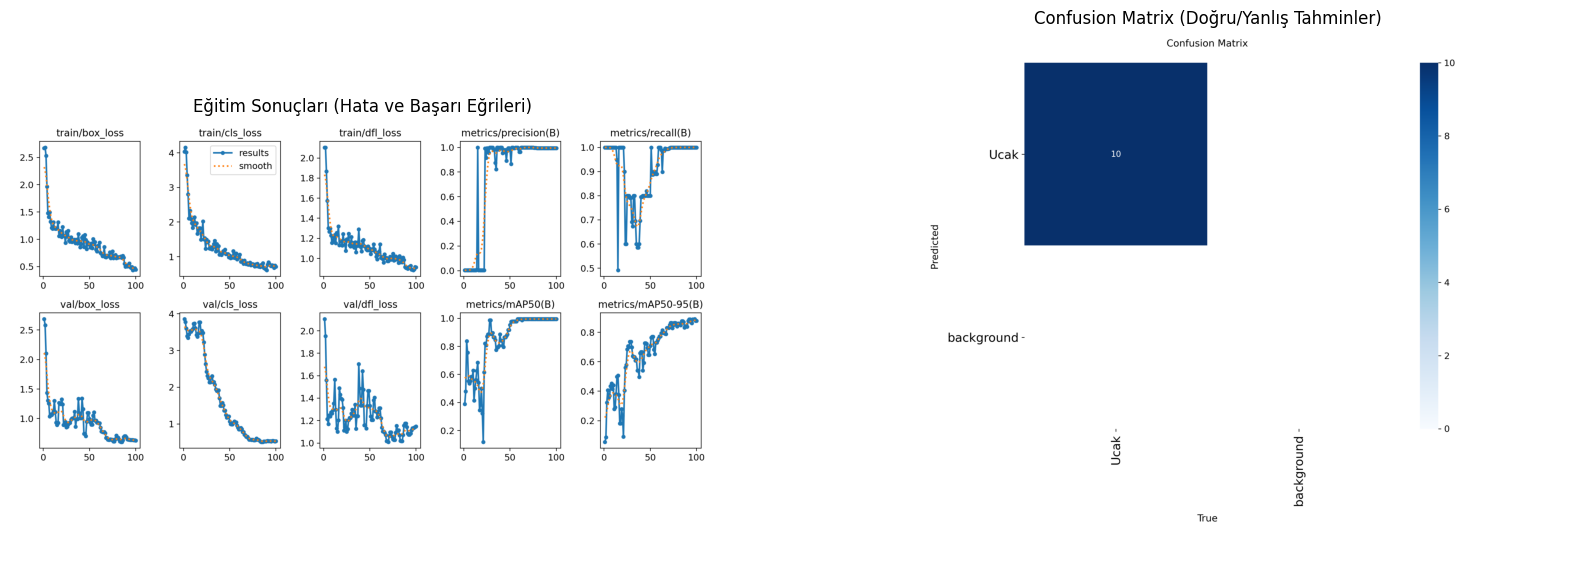

In [5]:
import cv2
import matplotlib.pyplot as plt

# 1. Genel Başarı Tablosu (Results)
# Bu grafik Loss (Hata) ve mAP (Başarı) eğrilerini içerir
results_path = 'runs/detect/train/results.png'

# 2. Karmaşıklık Matrisi (Confusion Matrix)
# Modelin neyi neyle karıştırdığını gösterir (Senin durumda sadece uçak var, o yüzden basit çıkacak)
matrix_path = 'runs/detect/train/confusion_matrix.png'

# --- Görüntüleme ---
plt.figure(figsize=(20, 10))

# Results Grafiği
if os.path.exists(results_path):
    img_res = cv2.imread(results_path)
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img_res, cv2.COLOR_BGR2RGB))
    plt.title("Eğitim Sonuçları (Hata ve Başarı Eğrileri)")
    plt.axis('off')
else:
    print("Results grafiği bulunamadı!")

# Confusion Matrix
if os.path.exists(matrix_path):
    img_mat = cv2.imread(matrix_path)
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(img_mat, cv2.COLOR_BGR2RGB))
    plt.title("Confusion Matrix (Doğru/Yanlış Tahminler)")
    plt.axis('off')
else:
    print("Confusion Matrix bulunamadı!")

plt.show()